# Урок 4. Алгоритм построения дерева решений

1. В коде из методички реализуйте один или несколько из критериев остановки (количество листьев, количество используемых признаков, глубина дерева и т.д.).
2. Для задачи классификации обучить дерево решений с использованием критериев разбиения Джини и Энтропия. Сравнить качество классификации, сделать выводы.
3. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [702]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import random
from sklearn import datasets

import numpy as np
import pandas as pd

In [298]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(
    n_samples=500,
    n_features = 2,
    n_informative = 2, 
    n_classes = 2,
    n_redundant=0, 
    n_clusters_per_class=1,
    flip_y=0.75,
    random_state=5)

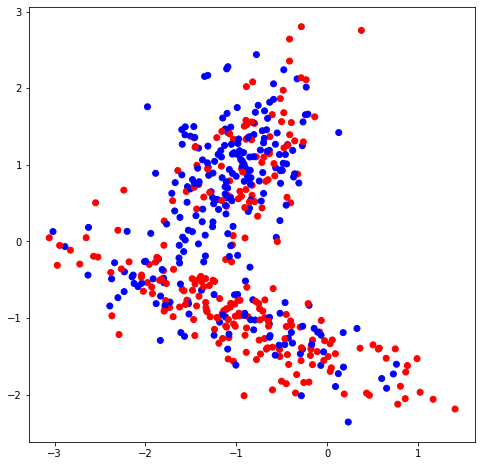

In [300]:
# визуализируем сгенерированные данные
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [246]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [387]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [135]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [167]:
# Расчет качества

def quality(left_labels, right_labels, current_impurity, impurity_func: callable = gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_impurity - p * impurity_func(left_labels) - (1 - p) * impurity_func(right_labels)

In [137]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [675]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, min_leaf: int = 5, impurity_func: callable = gini):
    
    current_impurity = impurity_func(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_impurity, impurity_func=impurity_func)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

Пытался сделать ограничения по листкам/узлам на очень маленьком дереве, на котором это заработало... По причине того что дереву хватало трех узлов для акураси 98% и все его false ветки были листьями)) На нормальных данных все полетело)  
  
Сегодня 23.09 (день дедлайна), я додумался, что можно сначала вширину дерево строить, через список тасков, например. Когда дерево не строится на два true узла подряд, а откладывает таск "создать тру ветку" в список, к которому вернется после просчета последней фолс ветки на текущей глубине дерева  
  
Вряд ли я за день это реализую в коде, что очень жаль... Поэтому пока что довольствуюсь только ограничением глубины и выбором критерия информативности

Работает ограничение в глубину и выбор критерия:

In [622]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, min_leaf: int = 5, depth_lim: int = np.inf, impurity_func: callable = gini, depth_i=1):
    
    quality, t, index = find_best_split(data, labels, min_leaf=min_leaf, impurity_func=impurity_func)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0 or depth_i > depth_lim:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    depth_i += 1
    true_branch = build_tree(true_data, true_labels, depth_lim=depth_lim, depth_i=depth_i)
    false_branch = build_tree(false_data, false_labels, depth_lim=depth_lim, depth_i=depth_i)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [25]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [26]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [309]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

## Задание 1. Реализуйте один или несколько из критериев остановки (количество листьев, количество используемых признаков, глубина дерева и т.д.).

In [341]:
# Построим самое простое дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels)

In [345]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

Text(0.5, 1.0, 'Test accuracy=57.33')

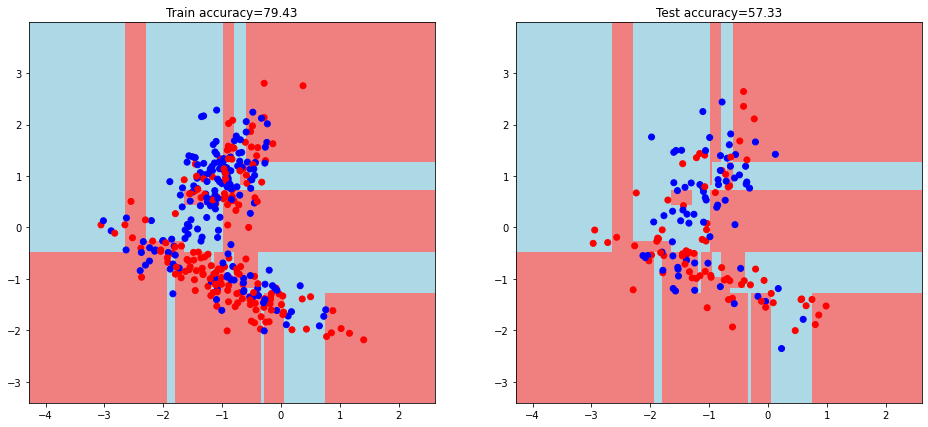

In [348]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)

# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))


xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)

# график обучающей выборки
plt.subplot(1,2,1)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors, shading='auto')
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors, shading='auto')
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

## Выбираем оптимальное ограничение дерева вглубину:

In [362]:
train_accuracy_log = []
test_accuracy_log = []

for i in range(1, 9):
    tree = build_tree(train_data, train_labels, depth_lim=i)
    
    tmp_train_accuracy = accuracy_metric(train_labels, predict(train_data, tree))
    tmp_test_accuracy = accuracy_metric(test_labels, predict(test_data, tree))
    
    train_accuracy_log.append(tmp_train_accuracy)
    test_accuracy_log.append(tmp_test_accuracy)
    
    print(i, tmp_train_accuracy, tmp_test_accuracy)

1 64.57142857142857 62.66666666666667
2 65.71428571428571 62.66666666666667
3 68.28571428571428 60.66666666666667
4 70.28571428571428 62.0
5 73.42857142857143 60.66666666666667
6 76.57142857142857 58.666666666666664
7 77.71428571428571 59.333333333333336
8 79.42857142857143 57.333333333333336


<function matplotlib.pyplot.show(close=None, block=None)>

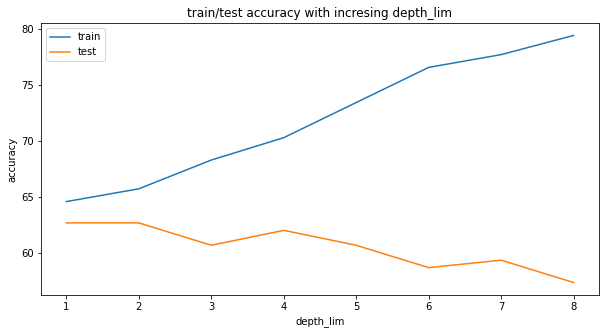

In [370]:
plt.figure(figsize=(10, 5))

plt.plot(range(1, 9), train_accuracy_log, label='train')
plt.plot(range(1, 9), test_accuracy_log, label='test')

plt.title('train/test accuracy with incresing depth_lim')
plt.xlabel('depth_lim')
plt.ylabel('accuracy')
plt.legend()

plt.show

Мы знаем, что деревья очень склонны к переобучению, поэтому неограниченная глубина ведет к большим потерям на тестовых результатах  
  
Видим, что чем больше значение ограничителя depth_lim - тем лучше accuracy на train и тем меньше на test  
  
Наша цель - сделать практичную модель, чтобы она наилучшим образом предсказывала тест. Лучшее значение тест мы получили, ограничив глубину на максимум (то есть получили всего 1 узел и 2 листка :) )  
  
Для этих данных - это оптимальный вариант

In [371]:
my_tree = build_tree(train_data, train_labels, depth_lim=1)

Text(0.5, 1.0, 'Test accuracy=62.67')

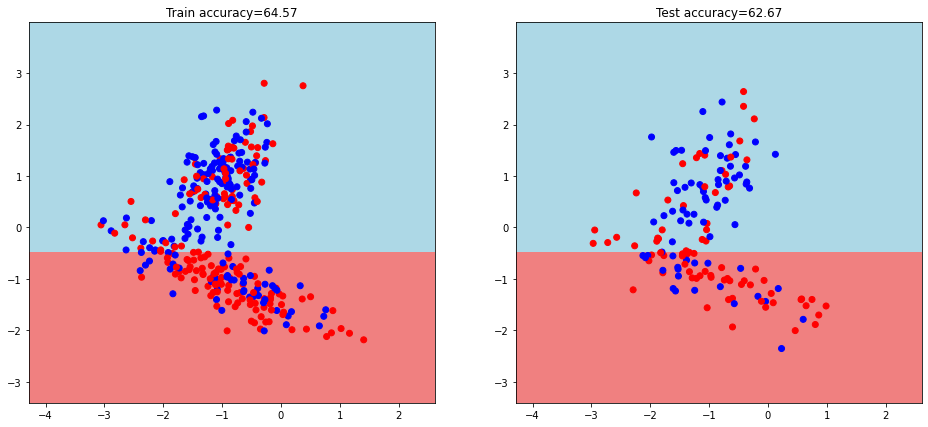

In [373]:
train_answers = predict(train_data, my_tree)
answers = predict(test_data, my_tree)
train_accuracy = accuracy_metric(train_labels, train_answers)
test_accuracy = accuracy_metric(test_labels, answers)

# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))


xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)

# график обучающей выборки
plt.subplot(1,2,1)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors, shading='auto')
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors, shading='auto')
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

## Задание 2. Для задачи классификации обучить дерево решений с использованием критериев разбиения Джини и Энтропия. Сравнить качество классификации, сделать выводы.

In [150]:
# Расчет энтропийного критерия информативности

def entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 0
    for label in classes:
        p = classes[label] / len(labels)
        impurity += p * np.log2(p)
        
    return -impurity

Я ввел в функции <code>build_tree(), find_best_split(), quality()</code> позиционный аргумент <code>impurity_func: callable = gini</code>  
  
Теперь при вызове дерева можно указывать какой критерий информативности оно будет учитывать <code>gini/entropy</code>  
  
По дефолту (если не ввести ничего - используется gini)
  
Построим дерево с энтропийным критерием и сравним с деревом использующим <code>gini</code>

In [374]:
# Построим дерево по обучающей выборке
my_tree_entropy = build_tree(train_data, train_labels, depth_lim=1, impurity_func=entropy)

Text(0.5, 1.0, 'Test accuracy=62.67')

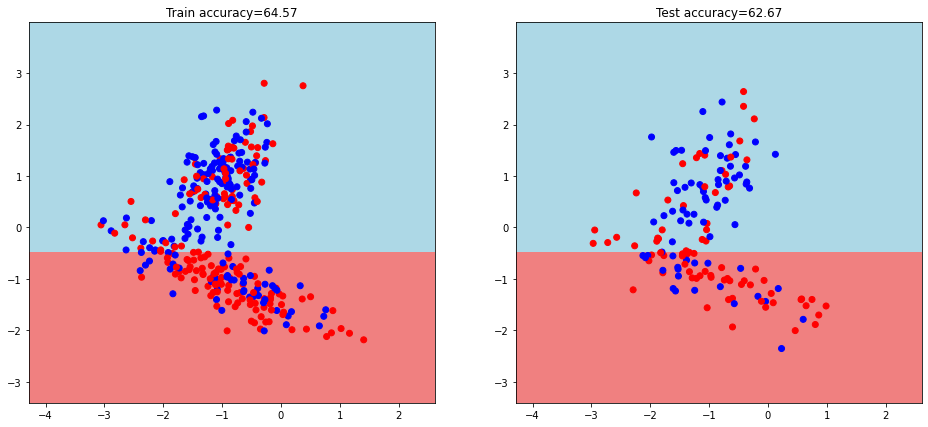

In [380]:
train_answers = predict(train_data, my_tree)
answers = predict(test_data, my_tree)
train_accuracy = accuracy_metric(train_labels, train_answers)
test_accuracy = accuracy_metric(test_labels, answers)

# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))


xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)

# график обучающей выборки
plt.subplot(1,2,1)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors, shading='auto')
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors, shading='auto')
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

На нашей выборке - весомых изменений не видно

## Задание 3. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

### Создаем данные

In [428]:
# creating data
X_y = datasets.make_regression(n_samples=400, n_features=1, n_informative=1, n_targets=1, \
                      bias=100, noise=20, shuffle=True, random_state=42)
X = X_y[0]
y = X_y[1]

<function matplotlib.pyplot.show(close=None, block=None)>

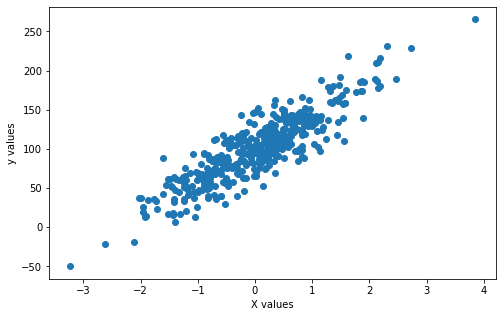

In [429]:
fig = plt.figure(figsize=(8, 5))
plt.scatter(X, y)
plt.xlabel('X values')
plt.ylabel('y values')
plt.show

#### Меняем в классе листа предикт функцию на расчет среднего значения по обьектам

In [386]:
class Leaf_Reg:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        return np.mean(self.labels)

#### Меняем критерий информативности на дисперсию

In [388]:
def _variance(labels):        
    return np.var(labels)

#### Заменяем создание класса обычного листа, на лист регрессии

In [674]:
def build_tree_reg(data, labels, min_leaf: int = 5, depth_lim: int = np.inf, impurity_func: callable = gini, depth_i=1):
    
    quality, t, index = find_best_split(data, labels, min_leaf=min_leaf, impurity_func=impurity_func)

    if quality == 0 or depth_i > depth_lim:
        return Leaf_Reg(data, labels) # вот тут заменяем класс листа на новый

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    depth_i += 1
    true_branch = build_tree_reg(true_data, true_labels, min_leaf=min_leaf, depth_lim=depth_lim, depth_i=depth_i)
    false_branch = build_tree_reg(false_data, false_labels, min_leaf=min_leaf, depth_lim=depth_lim, depth_i=depth_i)

    return Node(index, t, true_branch, false_branch)

#### Вместо accurcy_metric используем MSE

In [403]:
def calc_mse(y, y_pred):
    return np.mean((y - y_pred)**2)

Разбиваем данные на train/test

In [431]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, 
                                                                    test_size = 0.3, 
                                                                    random_state = 1)

In [644]:
def predict_value(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf_Reg):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return predict_value(obj, node.true_branch)
    else:
        return predict_value(obj, node.false_branch)

In [642]:
def predict_reg(data, tree):
    
    classes = []
    for obj in data:
        prediction = predict_value(obj, tree)
        classes.append(prediction)
    return classes

Строим дефолтное дерево, без ограничений

In [636]:
my_tree = build_tree_reg(X_train, y_train, impurity_func=_variance)

Подбираем значения для ограничения глубины дерева

In [647]:
train_mse_log = []
test_mse_log = []

for i in range(1, 22):
    tree = build_tree_reg(X_train, y_train, depth_lim=i, impurity_func=_variance)
    
    tmp_train_mse = calc_mse(y_train, predict_reg(X_train, tree))
    tmp_test_mse = calc_mse(y_test, predict_reg(X_test, tree))
    
    train_mse_log.append(tmp_train_mse)
    test_mse_log.append(tmp_test_mse)
    
    if i % 2 == 0:
        print(i, tmp_train_mse, tmp_test_mse)

2 604.4560258273347 831.0090922450783
4 477.5469896064693 663.8295630652084
6 443.5634500212141 597.5741153001977
8 404.1587314435381 563.1264835627427
10 384.1539255945492 560.552218516259
12 374.1350679080525 553.8005096502604
14 373.86226529331987 554.3103612368232
16 373.86226529331987 554.3103612368232
18 373.86226529331987 554.3103612368232
20 373.86226529331987 554.3103612368232


<function matplotlib.pyplot.show(close=None, block=None)>

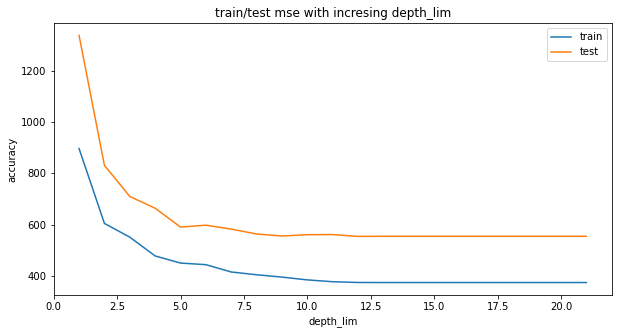

In [646]:
plt.figure(figsize=(10, 5))

plt.plot(range(1, 22), train_mse_log, label='train')
plt.plot(range(1, 22), test_mse_log, label='test')

plt.title('train/test mse with incresing depth_lim')
plt.xlabel('depth_lim')
plt.ylabel('accuracy')
plt.legend()

plt.show

***
Сверху на графике видно, что оптимальным значением ограничителя глубины будет 14
  
Ниже подбираем значения для min_leaf
***

In [738]:
train_mse_log = []
test_mse_log = []

for i in range(1, 32):
    tree = build_tree_reg(X_train, y_train, min_leaf=i, depth_lim=14, impurity_func=_variance)
    
    tmp_train_mse = calc_mse(y_train, predict_reg(X_train, tree))
    tmp_test_mse = calc_mse(y_test, predict_reg(X_test, tree))
    
    train_mse_log.append(tmp_train_mse)
    test_mse_log.append(tmp_test_mse)
    
    if i % 2 == 0:
        print(i, tmp_train_mse, tmp_test_mse)

2 285.7104629856959 717.3777996824227
4 334.7065762468853 569.4360164279252
6 363.0309659490328 593.8552964823011
8 407.0886628710561 592.3266565383373
10 425.88414615162344 613.3728577830673
12 437.0033414177782 590.9532819157994
14 441.2061697732676 586.3487688424959
16 442.9153668989272 588.8389335718452
18 445.31443629978065 593.4950013907252
20 456.7391750201032 588.0996257329624
22 469.58788870509596 582.187215636563
24 515.6166809764504 705.5277565593086
26 537.1449627506079 751.0207058617409
28 537.1449627506079 751.0207058617409
30 539.618986116896 753.2695252784746


<function matplotlib.pyplot.show(close=None, block=None)>

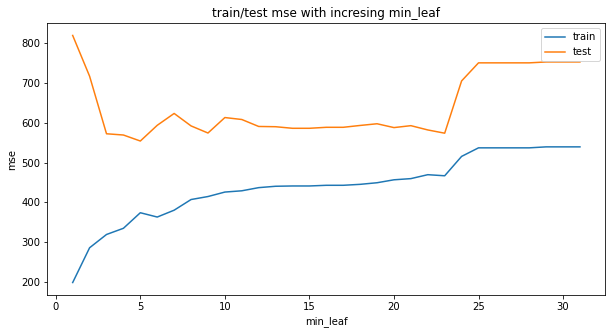

In [743]:
plt.figure(figsize=(10, 5))

plt.plot(range(1, 32), train_mse_log, label='train')
plt.plot(range(1, 32), test_mse_log, label='test')

plt.title('train/test mse with incresing min_leaf')
plt.xlabel('min_leaf')
plt.ylabel('mse')
plt.legend()

plt.show

***
Сверху видим, что подобрав depth_lim, подбирать значения min_leaf практически не имеет смысла, оставим в итоге дефолтное min_leaf = 5

Ниже я не успел причесать немного кода. Это бес-итератор, перебирает все комбинации min_leaf + depth_lim
***

In [717]:
log = {'i': [], 'n': [], 'mse_train': [], 'mse_test': []}

for i in range(1, 51):
    for n in range(1, 51):
        tree = build_tree_reg(X_train, y_train, i, depth_lim=n, impurity_func=_variance)

        tmp_train_mse = calc_mse(y_train, predict_reg(X_train, tree))
        tmp_test_mse = calc_mse(y_test, predict_reg(X_test, tree))

        log['mse_train'].append(tmp_train_mse)
        log['mse_test'].append(tmp_test_mse)
        log['i'].append(i)
        log['n'].append(n)

        if n % 2 == 0:
            print(i, n, tmp_train_mse, tmp_test_mse)

1 2 784.9199665265686 1298.7888296502686
1 4 588.3933281570228 821.6711831577835
1 6 451.4805271943268 677.5133603099429
1 8 380.3075703107658 682.6920494913459
1 10 303.0115656617035 678.015629069396
1 12 253.22556720885873 698.6317873346991
1 14 198.20746637340835 819.9747230203295
1 16 156.39816530780087 844.2801520823177
1 18 123.17101194363916 919.6229072483239
1 20 90.09444914530803 955.0514827000691
1 22 55.26446737059127 951.370388741674
1 24 40.39387325241486 966.3505450886692
1 26 27.427593196383558 966.8808642130086
1 28 8.031720872686801 964.9807286219569
1 30 0.0 990.4988984893415
1 32 0.0 990.4988984893415
1 34 0.0 990.4988984893415
1 36 0.0 990.4988984893415
1 38 0.0 990.4988984893415
1 40 0.0 990.4988984893415
1 42 0.0 990.4988984893415
1 44 0.0 990.4988984893415
1 46 0.0 990.4988984893415
1 48 0.0 990.4988984893415
1 50 0.0 990.4988984893415
2 2 782.0689409017814 1297.4217784083585
2 4 566.7897452950571 848.6529237342688
2 6 444.48830932316 693.0539543010011
2 8 384.76

9 8 418.4084775333616 573.1506442026329
9 10 414.62403212169266 574.4625104496281
9 12 414.62403212169266 574.4625104496281
9 14 414.62403212169266 574.4625104496281
9 16 414.62403212169266 574.4625104496281
9 18 414.62403212169266 574.4625104496281
9 20 414.62403212169266 574.4625104496281
9 22 414.62403212169266 574.4625104496281
9 24 414.62403212169266 574.4625104496281
9 26 414.62403212169266 574.4625104496281
9 28 414.62403212169266 574.4625104496281
9 30 414.62403212169266 574.4625104496281
9 32 414.62403212169266 574.4625104496281
9 34 414.62403212169266 574.4625104496281
9 36 414.62403212169266 574.4625104496281
9 38 414.62403212169266 574.4625104496281
9 40 414.62403212169266 574.4625104496281
9 42 414.62403212169266 574.4625104496281
9 44 414.62403212169266 574.4625104496281
9 46 414.62403212169266 574.4625104496281
9 48 414.62403212169266 574.4625104496281
9 50 414.62403212169266 574.4625104496281
10 2 603.0309022984611 759.7042870829468
10 4 464.4609776109991 608.3984274986

16 48 442.9153668989272 588.8389335718452
16 50 442.9153668989272 588.8389335718452
17 2 603.0309022984611 759.7042870829468
17 4 462.11681767597975 601.0739327544868
17 6 443.83332143281785 592.3283372398824
17 8 442.9153668989272 588.8389335718452
17 10 442.9153668989272 588.8389335718452
17 12 442.9153668989272 588.8389335718452
17 14 442.9153668989272 588.8389335718452
17 16 442.9153668989272 588.8389335718452
17 18 442.9153668989272 588.8389335718452
17 20 442.9153668989272 588.8389335718452
17 22 442.9153668989272 588.8389335718452
17 24 442.9153668989272 588.8389335718452
17 26 442.9153668989272 588.8389335718452
17 28 442.9153668989272 588.8389335718452
17 30 442.9153668989272 588.8389335718452
17 32 442.9153668989272 588.8389335718452
17 34 442.9153668989272 588.8389335718452
17 36 442.9153668989272 588.8389335718452
17 38 442.9153668989272 588.8389335718452
17 40 442.9153668989272 588.8389335718452
17 42 442.9153668989272 588.8389335718452
17 44 442.9153668989272 588.83893357

24 40 515.6166809764504 705.5277565593086
24 42 515.6166809764504 705.5277565593086
24 44 515.6166809764504 705.5277565593086
24 46 515.6166809764504 705.5277565593086
24 48 515.6166809764504 705.5277565593086
24 50 515.6166809764504 705.5277565593086
25 2 599.1654840453542 790.9578980754419
25 4 537.1449627506079 751.0207058617409
25 6 537.1449627506079 751.0207058617409
25 8 537.1449627506079 751.0207058617409
25 10 537.1449627506079 751.0207058617409
25 12 537.1449627506079 751.0207058617409
25 14 537.1449627506079 751.0207058617409
25 16 537.1449627506079 751.0207058617409
25 18 537.1449627506079 751.0207058617409
25 20 537.1449627506079 751.0207058617409
25 22 537.1449627506079 751.0207058617409
25 24 537.1449627506079 751.0207058617409
25 26 537.1449627506079 751.0207058617409
25 28 537.1449627506079 751.0207058617409
25 30 537.1449627506079 751.0207058617409
25 32 537.1449627506079 751.0207058617409
25 34 537.1449627506079 751.0207058617409
25 36 537.1449627506079 751.0207058617

32 36 539.618986116896 753.2695252784746
32 38 539.618986116896 753.2695252784746
32 40 539.618986116896 753.2695252784746
32 42 539.618986116896 753.2695252784746
32 44 539.618986116896 753.2695252784746
32 46 539.618986116896 753.2695252784746
32 48 539.618986116896 753.2695252784746
32 50 539.618986116896 753.2695252784746
33 2 599.1654840453542 790.9578980754419
33 4 526.2444941662089 745.6974405799417
33 6 526.2444941662089 745.6974405799417
33 8 526.2444941662089 745.6974405799417
33 10 526.2444941662089 745.6974405799417
33 12 526.2444941662089 745.6974405799417
33 14 526.2444941662089 745.6974405799417
33 16 526.2444941662089 745.6974405799417
33 18 526.2444941662089 745.6974405799417
33 20 526.2444941662089 745.6974405799417
33 22 526.2444941662089 745.6974405799417
33 24 526.2444941662089 745.6974405799417
33 26 526.2444941662089 745.6974405799417
33 28 526.2444941662089 745.6974405799417
33 30 526.2444941662089 745.6974405799417
33 32 526.2444941662089 745.6974405799417
33 3

40 34 567.6754354836218 756.4036739244468
40 36 567.6754354836218 756.4036739244468
40 38 567.6754354836218 756.4036739244468
40 40 567.6754354836218 756.4036739244468
40 42 567.6754354836218 756.4036739244468
40 44 567.6754354836218 756.4036739244468
40 46 567.6754354836218 756.4036739244468
40 48 567.6754354836218 756.4036739244468
40 50 567.6754354836218 756.4036739244468
41 2 599.1654840453542 790.9578980754419
41 4 568.2775093626112 759.3494152492497
41 6 568.2775093626112 759.3494152492497
41 8 568.2775093626112 759.3494152492497
41 10 568.2775093626112 759.3494152492497
41 12 568.2775093626112 759.3494152492497
41 14 568.2775093626112 759.3494152492497
41 16 568.2775093626112 759.3494152492497
41 18 568.2775093626112 759.3494152492497
41 20 568.2775093626112 759.3494152492497
41 22 568.2775093626112 759.3494152492497
41 24 568.2775093626112 759.3494152492497
41 26 568.2775093626112 759.3494152492497
41 28 568.2775093626112 759.3494152492497
41 30 568.2775093626112 759.3494152492

48 26 570.3003204622626 858.9113973924199
48 28 570.3003204622626 858.9113973924199
48 30 570.3003204622626 858.9113973924199
48 32 570.3003204622626 858.9113973924199
48 34 570.3003204622626 858.9113973924199
48 36 570.3003204622626 858.9113973924199
48 38 570.3003204622626 858.9113973924199
48 40 570.3003204622626 858.9113973924199
48 42 570.3003204622626 858.9113973924199
48 44 570.3003204622626 858.9113973924199
48 46 570.3003204622626 858.9113973924199
48 48 570.3003204622626 858.9113973924199
48 50 570.3003204622626 858.9113973924199
49 2 606.4159578112863 909.7303240501147
49 4 571.8822740276142 859.7139950262797
49 6 571.8822740276142 859.7139950262797
49 8 571.8822740276142 859.7139950262797
49 10 571.8822740276142 859.7139950262797
49 12 571.8822740276142 859.7139950262797
49 14 571.8822740276142 859.7139950262797
49 16 571.8822740276142 859.7139950262797
49 18 571.8822740276142 859.7139950262797
49 20 571.8822740276142 859.7139950262797
49 22 571.8822740276142 859.7139950262

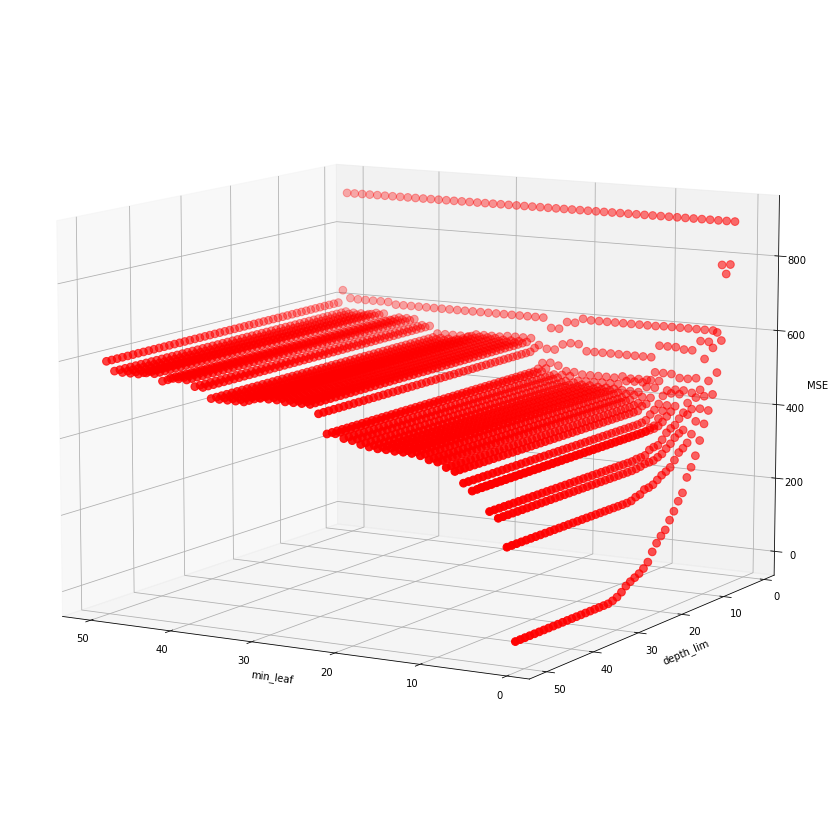

In [735]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.array(log['i']), np.array(log['n']), np.array(log['mse_train']), c='red', s=60)
ax.view_init(10, 120)

ax.set_xlabel('min_leaf')
ax.set_ylabel('depth_lim')
ax.set_zlabel('MSE')

plt.show()

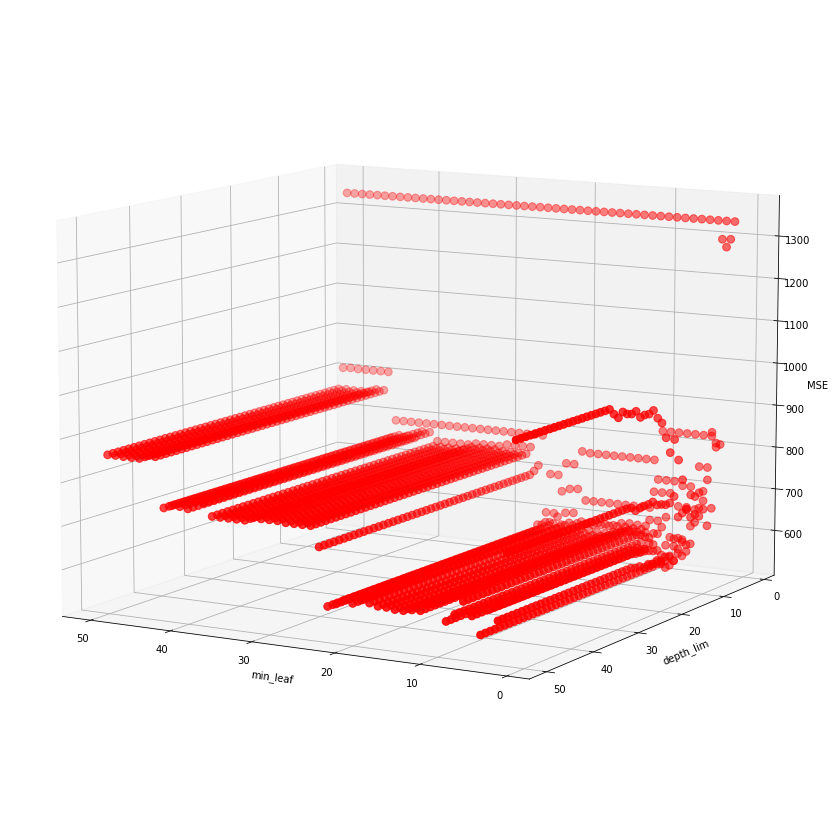

In [744]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.array(log['i']), np.array(log['n']), np.array(log['mse_test']), c='red', s=60)
ax.view_init(10, 120)

ax.set_xlabel('min_leaf')
ax.set_ylabel('depth_lim')
ax.set_zlabel('MSE')

plt.show()

Визуализация всех комбинаций min_leaf + depth_lim в рендже 1-50, для обоих параметров на train/test выборках  
  
Возьмем в итоге depth_lim = 14 и min_leaf = 14

<function matplotlib.pyplot.show(close=None, block=None)>

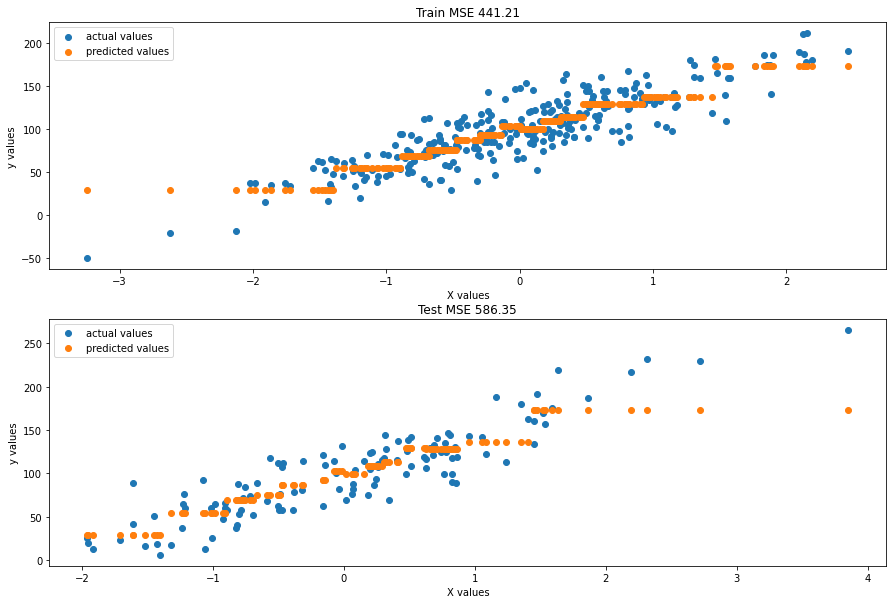

In [746]:
my_tree = build_tree_reg(X_train, y_train, min_leaf=14, depth_lim=14, impurity_func=_variance)

train_pred = predict_reg(X_train, my_tree)
test_pred = predict_reg(X_test, my_tree)

train_accuracy = calc_mse(y_train, train_pred)
test_accuracy = calc_mse(y_test, test_pred)

fig = plt.figure(figsize=(15, 10))

plt.subplot(211)
plt.scatter(X_train, y_train, label='actual values')
plt.scatter(X_train, train_pred, label='predicted values')
plt.title(f'Train MSE {train_accuracy:.2f}')
plt.xlabel('X values')
plt.ylabel('y values')
plt.legend()

plt.subplot(212)
plt.scatter(X_test, y_test, label='actual values')
plt.scatter(X_test, test_pred, label='predicted values')
plt.title(f'Test MSE {test_accuracy:.2f}')
plt.xlabel('X values')
plt.ylabel('y values')
plt.legend()

plt.show

***
На графике выше предсказанные значения выведены как scatter plot  
  
Ниже будут выведены как ломаный отрезок
***

<function matplotlib.pyplot.show(close=None, block=None)>

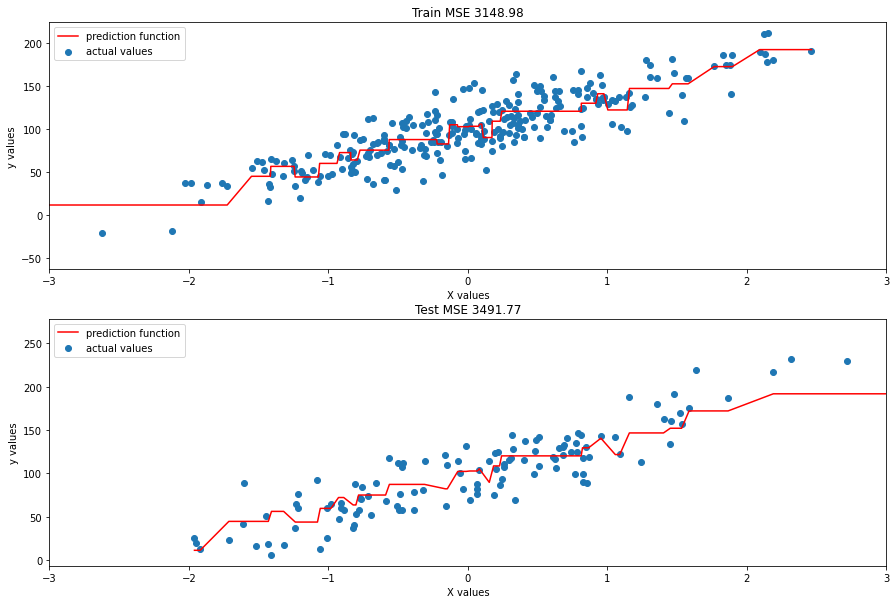

In [747]:
my_tree = build_tree_reg(X_train, y_train, depth_lim=8, impurity_func=_variance)

X_train_sorted = X_train.copy()
X_train_sorted = np.sort(X_train_sorted, axis=0)

X_test_sorted = X_test.copy()
X_test_sorted = np.sort(X_test_sorted, axis=0)

train_pred = predict_reg(X_train_sorted, my_tree)
test_pred = predict_reg(X_test_sorted, my_tree)

train_accuracy = calc_mse(y_train, train_pred)
test_accuracy = calc_mse(y_test, test_pred)

fig = plt.figure(figsize=(15, 10))

plt.subplot(211)
plt.scatter(X_train, y_train, label='actual values')
plt.plot(X_train_sorted, train_pred, label='prediction function', color='r')
plt.title(f'Train MSE {train_accuracy:.2f}')
plt.xlabel('X values')
plt.ylabel('y values')
plt.xlim(-3, 3)
plt.legend(loc='upper left')

plt.subplot(212)
plt.scatter(X_test, y_test, label='actual values')
plt.plot(X_test_sorted, test_pred, label='prediction function', color='r')
plt.title(f'Test MSE {test_accuracy:.2f}')
plt.xlabel('X values')
plt.ylabel('y values')
plt.xlim(-3, 3)
plt.legend(loc='upper left')

plt.show

Видно, что на самом деле, хоть подобранный критерий ограничения глубины и выдает лучшую MSE на нашей тестовой выборке - это все равно переобученное дерево  
  
В идеале, дерево должно выдать ломаную прямую, в виде ступенек вверх  
  
Похожий на нужный, результат получается, если ограничить глубину обучения до 2

***
Теперь хочу сделать дерево для нелинейной функции

<function matplotlib.pyplot.show(close=None, block=None)>

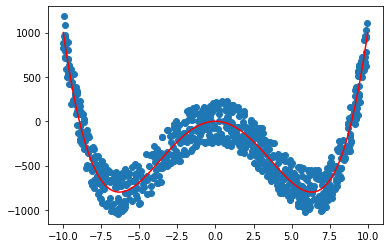

In [597]:
def y_pow_3(data):
    return (data ** 4) / 2 - (data ** 2) * 40

X_new = np.random.uniform(-10, 10, 800)
y_new = [y_pow_3(el) for el in X_new] +  np.random.uniform(-250, 250, 800)

X_new.resize(800, 1)
units = np.linspace(-10, 10, 100)

plt.scatter(X_new, y_new)
plt.plot(units, y_pow_3(units), c='r')

plt.show

In [598]:
X_new_train, X_new_test, y_new_train, y_new_test = model_selection.train_test_split(X_new, y_new, 
                                                                                    test_size = 0.3, 
                                                                                    random_state = 1)

In [599]:
my_tree = build_tree_reg(X_new_train, y_new_train, impurity_func=_variance)

In [748]:
train_accuracy_log = []
test_accuracy_log = []

for i in range(1, 37):
    tree = build_tree_reg(X_new_train, y_new_train, depth_lim=i, impurity_func=_variance)
    
    tmp_train_accuracy = calc_mse(y_new_train, predict_reg(X_new_train, tree))
    tmp_test_accuracy = calc_mse(y_new_test, predict_reg(X_new_test, tree))
    
    train_accuracy_log.append(tmp_train_accuracy)
    test_accuracy_log.append(tmp_test_accuracy)
    
    if i % 5 == 0:
        print(i, tmp_train_accuracy, tmp_test_accuracy)

5 100573.71162578721 96113.67186190597
10 86286.08913185685 83141.00373373917
15 63059.18223143936 63577.248367601525
20 34442.270568058106 39544.94177865971
25 22111.8644474362 26227.589606141784
30 20225.478809300188 25935.554320655825
35 20184.019961384063 25406.079041971025


<function matplotlib.pyplot.show(close=None, block=None)>

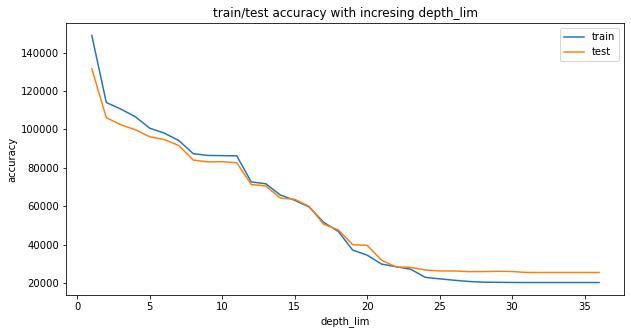

In [749]:
plt.figure(figsize=(10, 5))

plt.plot(range(1, 37), train_accuracy_log, label='train')
plt.plot(range(1, 37), test_accuracy_log, label='test')

plt.title('train/test accuracy with incresing depth_lim')
plt.xlabel('depth_lim')
plt.ylabel('accuracy')
plt.legend()

plt.show

In [751]:
train_accuracy_log = []
test_accuracy_log = []

for i in range(1, 37):
    tree = build_tree_reg(X_new_train, y_new_train, min_leaf=i, depth_lim=30, impurity_func=_variance)
    
    tmp_train_accuracy = calc_mse(y_new_train, predict_reg(X_new_train, tree))
    tmp_test_accuracy = calc_mse(y_new_test, predict_reg(X_new_test, tree))
    
    train_accuracy_log.append(tmp_train_accuracy)
    test_accuracy_log.append(tmp_test_accuracy)
    
    if i % 1 == 0:
        print(i, tmp_train_accuracy, tmp_test_accuracy)

1 14171.74161495172 42970.13138305762
2 18348.43354142478 31803.64678444779
3 20232.54754126805 28728.657120568074
4 18854.83221981515 26760.01727217326
5 20225.478809300188 25935.554320655825
6 19667.4429020107 25012.47942490049
7 20806.179792505278 24294.859831171467
8 22721.58706529715 25711.610935827073
9 22715.94072450598 27171.37638653469
10 23285.713655692412 26846.192170302213
11 24399.8891589147 26529.18305737554
12 24587.504646375663 27824.944860412383
13 26151.94545076883 27282.266114033224
14 26331.01155946903 27510.42955426867
15 25543.336309034235 26297.678618571117
16 26597.71543235597 27081.394461221385
17 26004.647876095467 28361.28067849027
18 32066.409503250543 32051.688398616345
19 32062.80403672109 31270.103661846064
20 34988.866389399365 34478.025019139146
21 34988.866389399365 34478.025019139146
22 35197.94218225952 35046.471763628615
23 34491.12949893688 30350.228763294257
24 34627.27405497183 30552.386866538793
25 36978.90161919557 38472.27796289398
26 36996.28

<function matplotlib.pyplot.show(close=None, block=None)>

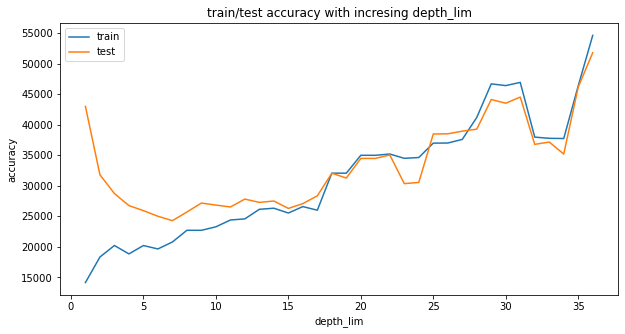

In [752]:
plt.figure(figsize=(10, 5))

plt.plot(range(1, 37), train_accuracy_log, label='train')
plt.plot(range(1, 37), test_accuracy_log, label='test')

plt.title('train/test accuracy with incresing depth_lim')
plt.xlabel('depth_lim')
plt.ylabel('accuracy')
plt.legend()

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

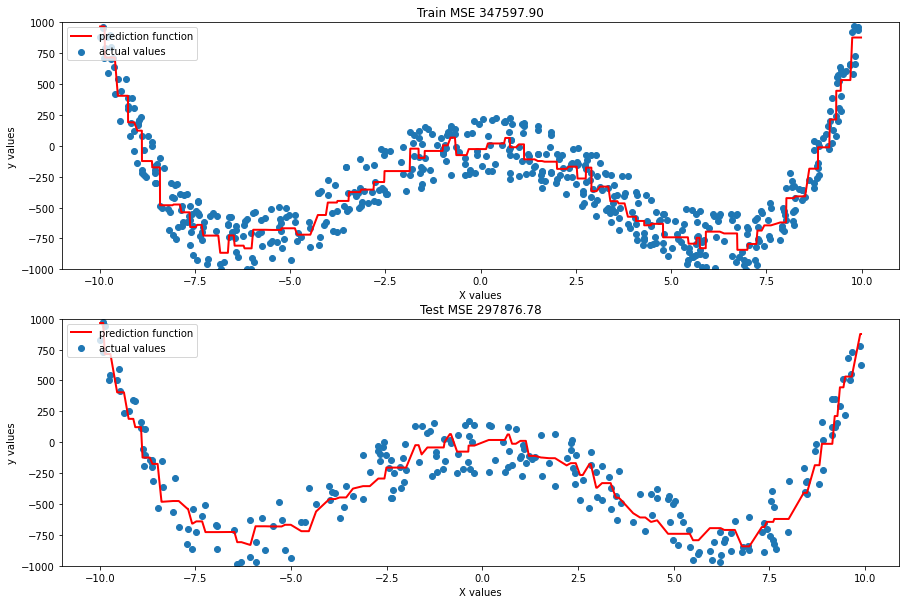

In [754]:
my_tree = build_tree_reg(X_new_train, y_new_train, min_leaf=6, depth_lim=30, impurity_func=_variance)

X_new_train_sorted = X_new_train.copy()
X_new_train_sorted = np.sort(X_new_train_sorted, axis=0)

X_new_test_sorted = X_new_test.copy()
X_new_test_sorted = np.sort(X_new_test_sorted, axis=0)

train_pred = predict_reg(X_new_train_sorted, my_tree)
test_pred = predict_reg(X_new_test_sorted, my_tree)

train_accuracy = calc_mse(y_new_train, train_pred)
test_accuracy = calc_mse(y_new_test, test_pred)

fig = plt.figure(figsize=(15, 10))

plt.subplot(211)
plt.scatter(X_new_train, y_new_train, label='actual values')
plt.plot(X_new_train_sorted, train_pred, label='prediction function', color='r', linewidth=2)
plt.title(f'Train MSE {train_accuracy:.2f}')
plt.xlabel('X values')
plt.ylabel('y values')
plt.ylim(-1000, 1000)
plt.legend(loc='upper left')

plt.subplot(212)
plt.scatter(X_new_test, y_new_test, label='actual values')
plt.plot(X_new_test_sorted, test_pred, label='prediction function', color='r', linewidth=2)
plt.title(f'Test MSE {test_accuracy:.2f}')
plt.xlabel('X values')
plt.ylabel('y values')
plt.ylim(-1000, 1000)
plt.legend(loc='upper left')

plt.show

Подобрав значения максимальной глубины и мин. кол-ва признаков в каждом листке - получилось добиться результата, как на графике выше. Модель достаточно практична 